# Exercicio 3

In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize, minimize_scalar, line_search
import time

In [2]:
nf = 0
ngrad = 0

In [3]:
def f(x):
    global nf
    nf += 1
    return  (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2 
    

def grad(x):
    global ngrad 
    ngrad += 1
    partial_x0 = 4 * x[0] * (x[0]**2 + x[1] - 11) + 2*(x[0] + x[1]**2 - 7)
    partial_x1 = 2 * (x[0]**2 + x[1] - 11) + 4 * x[1] * (x[0] + x[1]**2 - 7) 
    return np.array([partial_x0, partial_x1])
    

### plot da funçao f

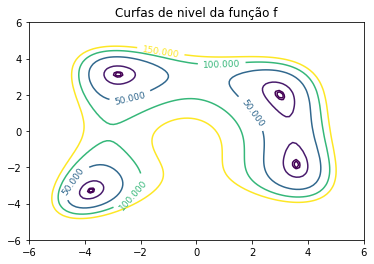

In [4]:
import matplotlib.pyplot as plt

def f2(x,y):
    return f(np.array([x,y]))
x = np.linspace(-6.0, 6.0, 100)
y = np.linspace(-6.0, 6.0, 100)
X,Y = np.meshgrid(x,y)
Z = np.vectorize(f2)(X,Y)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z, levels=np.array([0,0.5,1,10,50, 100, 150]))
ax.clabel(CS, fontsize=9, inline=1)
ax.set_title('Curfas de nivel da função f')
plt.show()

### Funçao para imprimir os resultados

In [5]:
def report(t0,res):
    t1=time.time()-t0
    print(" x = [",round(res.x[0],1),',',round(res.x[1],1),"]")
    print(' f(x) = ',round(f(res.x),3))
    print(' execution time = ',round(t1*1000.0,1), 'ms' )
    print(' n calls function = ',nf)
    print(' n calls grad = ',ngrad)
          
    
def reset():
    global nf
    global ngrad
    nf = 0
    ngrad = 0

# Otimizaçao

## CG


O minimize para o CG funciona tanto com e sem o gradiente. Vamos ver as 2 versões


### Sem o gradiente

In [6]:
reset()
t0=time.time()
res = minimize(f,[4, 4], method="CG")
report(t0,res)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  1.9 ms
 n calls function =  69
 n calls grad =  0


### Com o gradiente

In [7]:
reset()
t0=time.time()
res = minimize(f,[4, 4], method="CG", jac = grad)
report(t0,res)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  1.5 ms
 n calls function =  18
 n calls grad =  17


Mesma solução, mas ele gasta menos tempo usando o gradiente. Isso faz sentido pois o CG usa o gradiente, e portando se voce não esta passando a função de gradiente, ele vai aproxima-la usando diferenças entre chamadas do f

# BFGS

O BFGS tabem pode receber ou não o gradiente. Vamos ver as 2 versões 

### Sem o gradiente

In [8]:
reset()
t0=time.time()
res = minimize(f,[4, 4], method="L-BFGS-B")
report(t0,res)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  1.3 ms
 n calls function =  31
 n calls grad =  0


### Com o gradiente 

In [9]:
reset()
t0=time.time()
res = minimize(f,[4, 4], method="L-BFGS-B", jac = grad)
report(t0,res)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  0.7 ms
 n calls function =  11
 n calls grad =  10


## Nelder Mead

In [10]:
reset()
x0 = [[-4,-4], [-4,1],[4, -1]]
t0=time.time()
res = minimize(f, [0,0], method="Nelder-Mead", options={'initial_simplex': x0})
report(t0,res)

 x = [ 3.6 , -1.8 ]
 f(x) =  0.0
 execution time =  3.2 ms
 n calls function =  78
 n calls grad =  0


O Nelder Mead do `minimize` precisa receber o ponto inial mas ele nao usara esse ponto de passarmos o simplix (nesse caso triangulo) inicial.

## BOBYQA

In [11]:
import pybobyqa

In [12]:
reset()
t0=time.time()
res = pybobyqa.solve(f,[4, 4])
report(t0,res)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  117.9 ms
 n calls function =  59
 n calls grad =  0


## Line search

Há várias versões do GD com line search. O que alguns alunos não fizeram foi fazer o loop externo ao line search. Há um loop exteno tipo o GD controlado pela tolerancia (e o numero maximo de iterações). 

In [13]:
class Resposta:
    pass

def line1(f,grad,x0):
    niter = 0
    x = x0
    while niter<10000:
        pk = -grad(x)
        res = line_search(f,grad,x,pk)
        xnew = x + res[0]*pk
        # usando a tolerancia do exrcicio passado
        tol = np.linalg.norm(x-xnew)/np.linalg.norm(xnew)
        if tol < 1e-5:
            break
        x = xnew
        niter += 1
    res = Resposta()
    res.x = x
    res.niter = niter
    return res

In [14]:
reset()
t0=time.time()
res = line1(f,grad, np.array([4, 4]))
report(t0,res)
print("numero de iterações =",res.niter)

 x = [ -3.8 , -3.3 ]
 f(x) =  0.0
 execution time =  4.7 ms
 n calls function =  90
 n calls grad =  39
numero de iterações = 12


### Line search com exception

Pode-se tambem não usar a tolerancia. O line search vai gerar uma exception se ele nao achar o minimo e podemos usar isso para interromper o loop exteno

In [15]:
def line2(f,grad,x0):
    niter = 0
    x = x0
    while niter<10000:
        pk = -grad(x)
        try:
            res = line_search(f,grad,x,pk)
            xnew = x + res[0]*pk
        except:
            break
        x = xnew
        niter += 1
    res = Resposta()
    res.x = x
    res.niter = niter
    return res

In [16]:
reset()
t0=time.time()
res = line2(f,grad, np.array([4, 4]))
report(t0,res)
print("numero de iterações =",res.niter)

 x = [ -3.8 , -3.3 ]
 f(x) =  0.0
 execution time =  118.0 ms
 n calls function =  209
 n calls grad =  89
numero de iterações = 29


/Users/wainer/miniconda3/envs/bobyqa/lib/python3.8/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


### Usando o minimize_scalar

Usando o `minimize-scalar`. Neste caso eu tenho que criar uma função auxiliar que usa o x e o pk como "variavies globais". Da para fazer algo parecido usando o argumento args=() da função `minimize_scalar`.

In [17]:
def line3(f,grad,x0):
    def faux(alpha):
        return f(x+alpha*pk)
    niter = 0
    x = x0
    while niter<10000:
        pk = -grad(x)
    
        res = minimize_scalar(faux, method='brent')
        xnew = x + res.x*pk
        tol = np.linalg.norm(x-xnew)/np.linalg.norm(xnew)
        if tol < 1e-5:
            break
        x = xnew
        niter += 1
    res = Resposta()
    res.x = x
    res.niter = niter
    return res

In [18]:
reset()
t0=time.time()
res = line3(f,grad, np.array([4, 4]))
report(t0,res)
print("numero de iterações =",res.niter)

 x = [ 3.0 , 2.0 ]
 f(x) =  0.0
 execution time =  5.7 ms
 n calls function =  267
 n calls grad =  14
numero de iterações = 13


## Discussão